### 5. Word2Vec and Model Training

#### 5.1 Import Necessary Libraries

In [11]:
import pandas as pd
import numpy as np
import gensim
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

#### 5.2 Load Dataset

In [12]:
# Specify an encoding that might work, such as 'latin1'
encoding = 'latin1'
df = pd.read_csv(r'E:\Vocational\Lighthouse Labs\Flex Course\Projects\P06_Final Project\data\master.csv',encoding=encoding, low_memory=False)

# Adjust display options to show the full text if needed
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

#### 5.3 Preprocess the Data

In [13]:
# Drop unnecessary columns which are not needed
df = df.drop(columns=['caseId', 'applicantName','title','citation','decisionDate','respondent'])

# One-hot encode the specified columns
columns_to_encode = ['litigationGuardian','ancestry','age',
                     'citizenship','colour','creed','disability','ethnic origin',
                     'family status','gender expression','gender identity',
                     'marital status','place of origin','public assistance','race',
                     'record of offences','sex','sexual orientation','single status',
                     'accommodation','contracts','employment','goods','services',
                     'facilities', 'uniouns','trades','respondentCount','writtenSubmission',
                     'appearances','intervenor','appRep','resRep','adjudicator', 
                     'decisionType','adjudicatorCount','applicantCount']
df = pd.get_dummies(df, columns=columns_to_encode)

#### 5.4 Apply Word2Vec Vectorization

In [14]:
# Check if 'reasoning' column exists
if 'reasoning' not in df.columns:
    raise ValueError("The 'reasoning' column is not found in the CSV file.")

# Handle missing values by filling them with an empty string
df['reasoning'] = df['reasoning'].fillna('')

# Tokenize the 'reasoning' column into a list of sentences, where each sentence is a list of words
sentences = df['reasoning'].apply(lambda x: x.split()).tolist()

# Initialize and train the Word2Vec model
model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)

# Create a matrix where each row is the averaged word vector for each sentence
def get_sentence_vector(sentence, model):
    # Filter out words that are not in the model's vocabulary
    words = [word for word in sentence if word in model.wv.key_to_index]
    # If no words in the sentence are in the vocabulary, return a vector of zeros
    if not words:
        return np.zeros(model.vector_size)
    # Average the word vectors for the sentence
    return np.mean([model.wv[word] for word in words], axis=0)

# Apply the function to each sentence in the 'reasoning' column
X_w2v = np.array([get_sentence_vector(sentence, model) for sentence in sentences])

# Print the shape of the resulting Word2Vec matrix
print("Word2Vec matrix shape:", X_w2v.shape)

# Convert the Word2Vec matrix to a DataFrame
w2v_df = pd.DataFrame(X_w2v, columns=[f'w2v_{i}' for i in range(X_w2v.shape[1])])

# Drop the 'reasoning' column from the master DataFrame
df = df.drop(columns=['reasoning'])

# Combine the new Word2Vec features with the other features in the 'master' DataFrame
df = pd.concat([df.reset_index(drop=True), w2v_df.reset_index(drop=True)], axis=1)

# Print the shape of the updated master DataFrame
print("Updated master DataFrame shape:", df.shape)

#Display
df.head()

Word2Vec matrix shape: (1911, 100)
Updated master DataFrame shape: (1911, 228)


,labels,litigationGuardian_False,litigationGuardian_True,ancestry_False,ancestry_True,age_False,age_True,citizenship_False,citizenship_True,colour_False,colour_True,creed_False,creed_True,disability_False,disability_True,ethnic origin_False,ethnic origin_True,family status_False,family status_True,gender expression_False,gender expression_True,gender identity_False,gender identity_True,marital status_False,marital status_True,place of origin_False,place of origin_True,public assistance_False,public assistance_True,race_False,race_True,record of offences_False,record of offences_True,sex_False,sex_True,sexual orientation_False,sexual orientation_True,single status_False,accommodation_False,accommodation_True,contracts_False,contracts_True,employment_False,employment_True,goods_False,goods_True,services_False,services_True,facilities_False,facilities_True,uniouns_False,trades_False,trades_True,respondentCount_multiple,respondentCount_single,writtenSubmission_False,writtenSubmission_True,appearances_False,appearances_True,intervenor_Counsel,intervenor_No Appearance,intervenor_Not Applicable,appRep_Counsel,appRep_No Appearance,appRep_Not Applicable,appRep_Paralegal,appRep_Representative,appRep_Self-represented,appRep_Student-at-law,resRep_Counsel,resRep_No Appearance,resRep_Not Applicable,resRep_Paralegal,resRep_Representative,resRep_Self-represented,adjudicator_Amanda Connolley,adjudicator_Ann Marie Yantz,adjudicator_Anthony Michael Tamburro,adjudicator_Aslam Daud,adjudicator_Caroline Sand,adjudicator_Cyndee Todgham Cherniak,adjudicator_David Langlois,adjudicator_Denise Ghanam,adjudicator_Eva Nichols,adjudicator_Fiona Keith,adjudicator_Gulzar Ladhani,adjudicator_Haniya Sheikh,adjudicator_Holly Gomes,adjudicator_Ivana Vaccaro,adjudicator_Jaime Seidner,adjudicator_Joseph Tascona,adjudicator_Karen Dawson,adjudicator_Karen Mason,adjudicator_Kelly Barker,adjudicator_Kimberley Westfall-Connor,adjudicator_Larry Swartz,adjudicator_Lavinia Inbar,adjudicator_Lawrence Feldman,adjudicator_Leah Simon,adjudicator_Marinus Lamers,adjudicator_Mario Silva,"adjudicator_Mario Silva, Mark Borer, Ninder Thind",adjudicator_Mark Borer,adjudicator_Marla Burstyn,adjudicator_Martin Forget,adjudicator_Mary MacNeill,adjudicator_Matthew M. LÃ©tourneau,adjudicator_Meryl Zisman Gary,adjudicator_Ninder Thind,adjudicator_Rafeena Bacchus,adjudicator_Robert Ciriello,adjudicator_Robert Gabor,adjudicator_Robert Patchett,adjudicator_Romona Gananathan,adjudicator_Roslyn Mounsey,adjudicator_Simon Dann,adjudicator_Thomas Elliot,adjudicator_Will McNair,adjudicator_William Luke,decisionType_DECISION,decisionType_DECISION ON REMEDY,decisionType_INTERIM DECISION,decisionType_POST JUDGEMENT DECISION,decisionType_RECONSIDERATION DECISION,adjudicatorCount_multiple,adjudicatorCount_single,applicantCount_multiple,applicantCount_single,w2v_0,w2v_1,w2v_2,w2v_3,w2v_4,w2v_5,w2v_6,w2v_7,w2v_8,w2v_9,w2v_10,w2v_11,w2v_12,w2v_13,w2v_14,w2v_15,w2v_16,w2v_17,w2v_18,w2v_19,w2v_20,w2v_21,w2v_22,w2v_23,w2v_24,w2v_25,w2v_26,w2v_27,w2v_28,w2v_29,w2v_30,w2v_31,w2v_32,w2v_33,w2v_34,w2v_35,w2v_36,w2v_37,w2v_38,w2v_39,w2v_40,w2v_41,w2v_42,w2v_43,w2v_44,w2v_45,w2v_46,w2v_47,w2v_48,w2v_49,w2v_50,w2v_51,w2v_52,w2v_53,w2v_54,w2v_55,w2v_56,w2v_57,w2v_58,w2v_59,w2v_60,w2v_61,w2v_62,w2v_63,w2v_64,w2v_65,w2v_66,w2v_67,w2v_68,w2v_69,w2v_70,w2v_71,w2v_72,w2v_73,w2v_74,w2v_75,w2v_76,w2v_77,w2v_78,w2v_79,w2v_80,w2v_81,w2v_82,w2v_83,w2v_84,w2v_85,w2v_86,w2v_87,w2v_88,w2v_89,w2v_90,w2v_91,w2v_92,w2v_93,w2v_94,w2v_95,w2v_96,w2v_97,w2v_98,w2v_99
0,abandoned,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,1,0,1,0,1,0,1,0,1,0,1,0,1,1,0,0,0,1,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,-0.746488,0.405633,-0.491892,-1.680365,-0.039465,-0.757014,0.374055,0.682953,-0.743169,-1.187421,0.843234,-0.545164,-0.954357,-0.148636,0.084004,-0.425625,1.053219,0.288167,0.294636,-0.789408,0.493848,0.796890,0

#### 5.5 Split Data into Features and Target

In [15]:
X = df.drop(columns=['labels'])
y = df['labels']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### 5.6 Handle Class Imbalance with SMOTE

In [16]:
# Apply SMOTE to the training set
smote = SMOTE(random_state=42, k_neighbors=2)
X_train, y_train = smote.fit_resample(X_train, y_train)

#### 4.7 Logistic Regression Model

In [17]:
# Create a pipeline for scaling and logistic regression
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('logistic_regression', LogisticRegression(max_iter=500))
])

# Train the model
pipeline.fit(X_train, y_train)

# Evaluate on training set
y_pred_train = pipeline.predict(X_train)
accuracy_train = accuracy_score(y_train, y_pred_train)
precision_train = precision_score(y_train, y_pred_train, average='weighted', zero_division=0)
recall_train = recall_score(y_train, y_pred_train, average='weighted', zero_division=0)
f1_train = f1_score(y_train, y_pred_train, average='weighted', zero_division=0)

# Print training set results
print(f'Logistic Regression (Train) - Accuracy: {accuracy_train:.4f}, Precision: {precision_train:.4f}, Recall: {recall_train:.4f}, F1 Score: {f1_train:.4f}')
print('Classification Report (Train):')
print(classification_report(y_train, y_pred_train, zero_division=0))

Logistic Regression (Train) - Accuracy: 0.9998, Precision: 0.9998, Recall: 0.9998, F1 Score: 0.9998
Classification Report (Train):
                  precision    recall  f1-score   support

       abandoned       1.00      1.00      1.00       960
abuse of process       1.00      1.00      1.00       960
       amendment       1.00      1.00      1.00       960
       applicant       1.00      1.00      1.00       960
          barred       1.00      1.00      1.00       960
      concurrent       1.00      1.00      1.00       960
        deferred       1.00      1.00      1.00       960
        hearing        1.00      1.00      1.00       960
       mediation       1.00      1.00      1.00       960
 nonjurisdiction       1.00      1.00      1.00       960
       permitted       1.00      1.00      1.00       960
      prohibited       1.00      1.00      1.00       960
  request denied       1.00      1.00      1.00       960
 request granted       1.00      1.00      1.00       96

In [18]:
# Evaluate on test set
y_pred_test = pipeline.predict(X_test)
accuracy_test = accuracy_score(y_test, y_pred_test)
precision_test = precision_score(y_test, y_pred_test, average='weighted', zero_division=0)
recall_test = recall_score(y_test, y_pred_test, average='weighted', zero_division=0)
f1_test = f1_score(y_test, y_pred_test, average='weighted', zero_division=0)

# Print test set results
print(f'Logistic Regression (Test) - Accuracy: {accuracy_test:.4f}, Precision: {precision_test:.4f}, Recall: {recall_test:.4f}, F1 Score: {f1_test:.4f}')
print('Classification Report (Test):')
print(classification_report(y_test, y_pred_test, zero_division=0))

Logistic Regression (Test) - Accuracy: 0.8198, Precision: 0.8302, Recall: 0.8198, F1 Score: 0.8215
Classification Report (Test):
                  precision    recall  f1-score   support

       abandoned       0.97      0.97      0.97       237
abuse of process       0.50      0.50      0.50         8
       amendment       0.50      0.60      0.55         5
       applicant       1.00      0.50      0.67         2
          barred       0.33      0.50      0.40         2
      concurrent       0.00      0.00      0.00         2
        deferred       0.50      0.50      0.50         2
        hearing        0.25      0.38      0.30         8
       mediation       0.20      0.17      0.18         6
 nonjurisdiction       0.81      0.76      0.79        34
       permitted       0.20      0.29      0.24         7
      prohibited       0.33      1.00      0.50         1
  request denied       0.88      0.80      0.83        44
 request granted       0.12      0.11      0.12         9


#### 4.8 Random Forest Model

In [19]:
# Train a RandomForestClassifier
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)

# Evaluate on training set
y_pred_train_rf = rf_model.predict(X_train)
accuracy_train_rf = accuracy_score(y_train, y_pred_train_rf)
precision_train_rf = precision_score(y_train, y_pred_train_rf, average='weighted', zero_division=0)
recall_train_rf = recall_score(y_train, y_pred_train_rf, average='weighted', zero_division=0)
f1_train_rf = f1_score(y_train, y_pred_train_rf, average='weighted', zero_division=0)

# Print training set results for Random Forest
print(f'Random Forest (Train) - Accuracy: {accuracy_train_rf:.4f}, Precision: {precision_train_rf:.4f}, Recall: {recall_train_rf:.4f}, F1 Score: {f1_train_rf:.4f}')
print('Classification Report (Train):')
print(classification_report(y_train, y_pred_train_rf, zero_division=0))

Random Forest (Train) - Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000
Classification Report (Train):
                  precision    recall  f1-score   support

       abandoned       1.00      1.00      1.00       960
abuse of process       1.00      1.00      1.00       960
       amendment       1.00      1.00      1.00       960
       applicant       1.00      1.00      1.00       960
          barred       1.00      1.00      1.00       960
      concurrent       1.00      1.00      1.00       960
        deferred       1.00      1.00      1.00       960
        hearing        1.00      1.00      1.00       960
       mediation       1.00      1.00      1.00       960
 nonjurisdiction       1.00      1.00      1.00       960
       permitted       1.00      1.00      1.00       960
      prohibited       1.00      1.00      1.00       960
  request denied       1.00      1.00      1.00       960
 request granted       1.00      1.00      1.00       960
    

In [20]:
# Evaluate on test set
y_pred_test_rf = rf_model.predict(X_test)
accuracy_test_rf = accuracy_score(y_test, y_pred_test_rf)
precision_test_rf = precision_score(y_test, y_pred_test_rf, average='weighted', zero_division=0)
recall_test_rf = recall_score(y_test, y_pred_test_rf, average='weighted', zero_division=0)
f1_test_rf = f1_score(y_test, y_pred_test_rf, average='weighted', zero_division=0)

# Print test set results for Random Forest
print(f'Random Forest (Test) - Accuracy: {accuracy_test_rf:.4f}, Precision: {precision_test_rf:.4f}, Recall: {recall_test_rf:.4f}, F1 Score: {f1_test_rf:.4f}')
print('Classification Report (Test):')
print(classification_report(y_test, y_pred_test_rf, zero_division=0))

Random Forest (Test) - Accuracy: 0.8616, Precision: 0.8585, Recall: 0.8616, F1 Score: 0.8569
Classification Report (Test):
                  precision    recall  f1-score   support

       abandoned       0.98      0.99      0.99       237
abuse of process       0.67      0.75      0.71         8
       amendment       0.50      0.80      0.62         5
       applicant       0.50      0.50      0.50         2
          barred       0.50      0.50      0.50         2
      concurrent       0.00      0.00      0.00         2
        deferred       0.25      0.50      0.33         2
        hearing        0.18      0.25      0.21         8
       mediation       0.67      0.33      0.44         6
 nonjurisdiction       0.86      0.94      0.90        34
       permitted       0.40      0.29      0.33         7
      prohibited       0.00      0.00      0.00         1
  request denied       0.92      0.82      0.87        44
 request granted       0.29      0.22      0.25         9
      

#### 4.9 XGBoost Model

In [21]:
# Encode target labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)

# Train an XGBoost model
xgb_model = XGBClassifier()
xgb_model.fit(X_train, y_train_encoded)

# Evaluate on training set
y_pred_train_xgb = xgb_model.predict(X_train)
accuracy_train_xgb = accuracy_score(y_train_encoded, y_pred_train_xgb)
precision_train_xgb = precision_score(y_train_encoded, y_pred_train_xgb, average='weighted', zero_division=0)
recall_train_xgb = recall_score(y_train_encoded, y_pred_train_xgb, average='weighted', zero_division=0)
f1_train_xgb = f1_score(y_train_encoded, y_pred_train_xgb, average='weighted', zero_division=0)

# Print training set results for XGBoost
print(f'XGBoost (Train) - Accuracy: {accuracy_train_xgb:.4f}, Precision: {precision_train_xgb:.4f}, Recall: {recall_train_xgb:.4f}, F1 Score: {f1_train_xgb:.4f}')
print('Classification Report (Train):')
print(classification_report(y_train_encoded, y_pred_train_xgb, zero_division=0))

XGBoost (Train) - Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000
Classification Report (Train):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       960
           1       1.00      1.00      1.00       960
           2       1.00      1.00      1.00       960
           3       1.00      1.00      1.00       960
           4       1.00      1.00      1.00       960
           5       1.00      1.00      1.00       960
           6       1.00      1.00      1.00       960
           7       1.00      1.00      1.00       960
           8       1.00      1.00      1.00       960
           9       1.00      1.00      1.00       960
          10       1.00      1.00      1.00       960
          11       1.00      1.00      1.00       960
          12       1.00      1.00      1.00       960
          13       1.00      1.00      1.00       960
          14       1.00      1.00      1.00       960
          15    

In [22]:
# Encode target labels
y_test_encoded = label_encoder.fit_transform(y_test)

# Evaluate on training set
y_pred_test_xgb = xgb_model.predict(X_test)
accuracy_test_xgb = accuracy_score(y_test_encoded, y_pred_test_xgb)
precision_test_xgb = precision_score(y_test_encoded, y_pred_test_xgb, average='weighted', zero_division=0)
recall_test_xgb = recall_score(y_test_encoded, y_pred_test_xgb, average='weighted', zero_division=0)
f1_test_xgb = f1_score(y_test_encoded, y_pred_test_xgb, average='weighted', zero_division=0)

# Print training set results for XGBoost
print(f'XGBoost (Train) - Accuracy: {accuracy_test_xgb:.4f}, Precision: {precision_test_xgb:.4f}, Recall: {recall_test_xgb:.4f}, F1 Score: {f1_test_xgb:.4f}')
print('Classification Report (Train):')
print(classification_report(y_train_encoded, y_pred_train_xgb, zero_division=0))

XGBoost (Train) - Accuracy: 0.8486, Precision: 0.8486, Recall: 0.8486, F1 Score: 0.8466
Classification Report (Train):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       960
           1       1.00      1.00      1.00       960
           2       1.00      1.00      1.00       960
           3       1.00      1.00      1.00       960
           4       1.00      1.00      1.00       960
           5       1.00      1.00      1.00       960
           6       1.00      1.00      1.00       960
           7       1.00      1.00      1.00       960
           8       1.00      1.00      1.00       960
           9       1.00      1.00      1.00       960
          10       1.00      1.00      1.00       960
          11       1.00      1.00      1.00       960
          12       1.00      1.00      1.00       960
          13       1.00      1.00      1.00       960
          14       1.00      1.00      1.00       960
          15    

#### 4.10 Support Vector Machine (SVM) Model with Kernel Evaluation

In [23]:
def evaluate_kernel(X_train, y_train):
    """
    Evaluate different SVM kernels on the training data, and track accuracy, precision, recall, and F1 score.
    """
    kernels = ['linear', 'poly', 'rbf', 'sigmoid']
    best_kernel = None
    best_score = -np.inf
    best_metrics = {}

    for kernel in kernels:
        print(f"Testing kernel: {kernel}")
        
        # Create a pipeline with scaling and SVM
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('svm', SVC(kernel=kernel))
        ])
        
        # Train the model
        pipeline.fit(X_train, y_train)

        # Make predictions
        y_pred = pipeline.predict(X_train)
        
        # Calculate metrics
        accuracy = accuracy_score(y_train, y_pred)
        precision = precision_score(y_train, y_pred, average='weighted', zero_division=0)
        recall = recall_score(y_train, y_pred, average='weighted', zero_division=0)
        f1 = f1_score(y_train, y_pred, average='weighted', zero_division=0)
        
        # Print metrics for current kernel
        print(f"Kernel: {kernel}, Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")
        
        # Determine the best kernel based on F1 score (or any other metric)
        if f1 > best_score:
            best_score = f1
            best_kernel = kernel
            best_metrics = {
                'accuracy': accuracy,
                'precision': precision,
                'recall': recall,
                'f1_score': f1
            }

    # Print the best kernel and corresponding metrics
    print(f"\nBest kernel: {best_kernel}")
    print(f"Best metrics: {best_metrics}")
    
    return best_kernel, best_metrics

# Evaluate different SVM kernels
best_kernel, best_metrics = evaluate_kernel(X_train, y_train)

Testing kernel: linear
Kernel: linear, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000
Testing kernel: poly
Kernel: poly, Accuracy: 0.9956, Precision: 0.9956, Recall: 0.9956, F1 Score: 0.9956
Testing kernel: rbf
Kernel: rbf, Accuracy: 0.9979, Precision: 0.9979, Recall: 0.9979, F1 Score: 0.9979
Testing kernel: sigmoid
Kernel: sigmoid, Accuracy: 0.9091, Precision: 0.9086, Recall: 0.9091, F1 Score: 0.9078

Best kernel: linear
Best metrics: {'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1_score': 1.0}


In [24]:
def evaluate_kernel(X_test, y_test):
    """
    Evaluate different SVM kernels on the training data, and track accuracy, precision, recall, and F1 score.
    """
    kernels = ['linear', 'poly', 'rbf', 'sigmoid']
    best_kernel = None
    best_score = -np.inf
    best_metrics = {}

    for kernel in kernels:
        print(f"Testing kernel: {kernel}")
        
        # Create a pipeline with scaling and SVM
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('svm', SVC(kernel=kernel))
        ])
        
        # Train the model
        pipeline.fit(X_train, y_train)

        # Make predictions
        y_pred = pipeline.predict(X_test)
        
        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
        recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
        f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
        
        # Print metrics for current kernel
        print(f"Kernel: {kernel}, Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")
        
        # Determine the best kernel based on F1 score (or any other metric)
        if f1 > best_score:
            best_score = f1
            best_kernel = kernel
            best_metrics = {
                'accuracy': accuracy,
                'precision': precision,
                'recall': recall,
                'f1_score': f1
            }

    # Print the best kernel and corresponding metrics
    print(f"\nBest kernel: {best_kernel}")
    print(f"Best metrics: {best_metrics}")
    
    return best_kernel, best_metrics

# Evaluate different SVM kernels
best_kernel, best_metrics = evaluate_kernel(X_test, y_test)

Testing kernel: linear
Kernel: linear, Accuracy: 0.8329, Precision: 0.8483, Recall: 0.8329, F1 Score: 0.8366
Testing kernel: poly
Kernel: poly, Accuracy: 0.8198, Precision: 0.8314, Recall: 0.8198, F1 Score: 0.8237
Testing kernel: rbf
Kernel: rbf, Accuracy: 0.8251, Precision: 0.7942, Recall: 0.8251, F1 Score: 0.8032
Testing kernel: sigmoid
Kernel: sigmoid, Accuracy: 0.7990, Precision: 0.8353, Recall: 0.7990, F1 Score: 0.8106

Best kernel: linear
Best metrics: {'accuracy': 0.8328981723237598, 'precision': 0.8482999408452488, 'recall': 0.8328981723237598, 'f1_score': 0.8365969894926829}


#### Visualizations

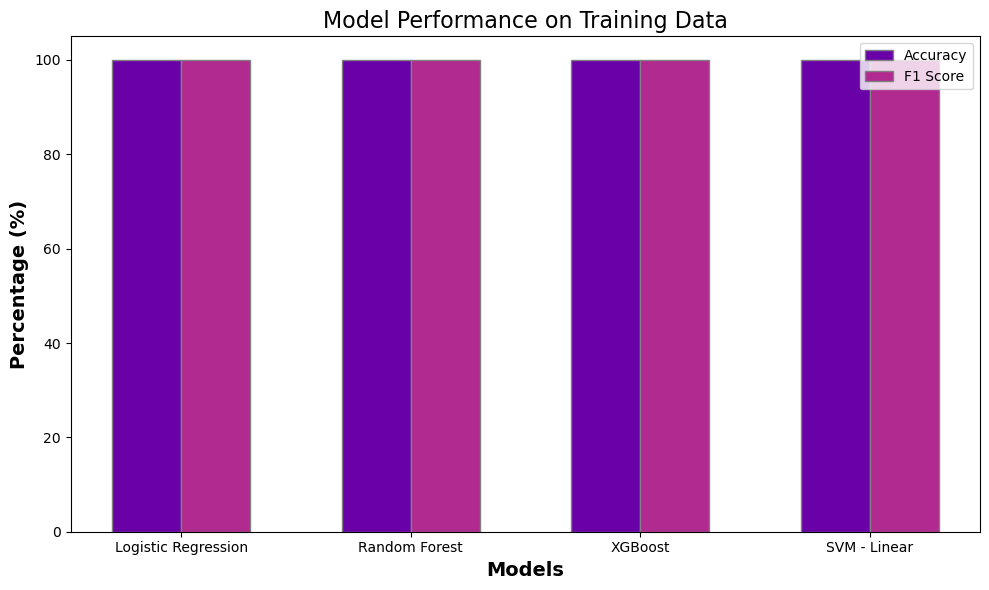

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define color palette
colors = sns.color_palette("plasma", 4)

# Model performance metrics
models = ['Logistic Regression', 'Random Forest', 'XGBoost', 'SVM - Linear']
accuracy = [0.9998, 1.000, 1.000, 1.000]  # Placeholder values
f1_score = [0.9998, 1.000, 1.000, 1.000]  # Placeholder values

# Convert to percentages
accuracy = [x * 100 for x in accuracy]
f1_score = [x * 100 for x in f1_score]

# Bar plot for model performance
plt.figure(figsize=(10, 6))
bar_width = 0.3
r1 = np.arange(len(models))
r2 = [x + bar_width for x in r1]

bars1 = plt.bar(r1, accuracy, color=colors[0], width=bar_width, edgecolor='grey', label='Accuracy')
bars2 = plt.bar(r2, f1_score, color=colors[1], width=bar_width, edgecolor='grey', label='F1 Score')

# Add labels and title
plt.xlabel('Models', fontweight='bold', fontsize=14)
plt.ylabel('Percentage (%)', fontweight='bold', fontsize=14)
plt.title('Model Performance on Training Data', fontsize=16)
plt.xticks([r + bar_width / 2 for r in range(len(models))], models)

# Show plot
plt.legend()
plt.tight_layout()
plt.show()

#### 4.12 Performance Comparison of Models (Test Data)

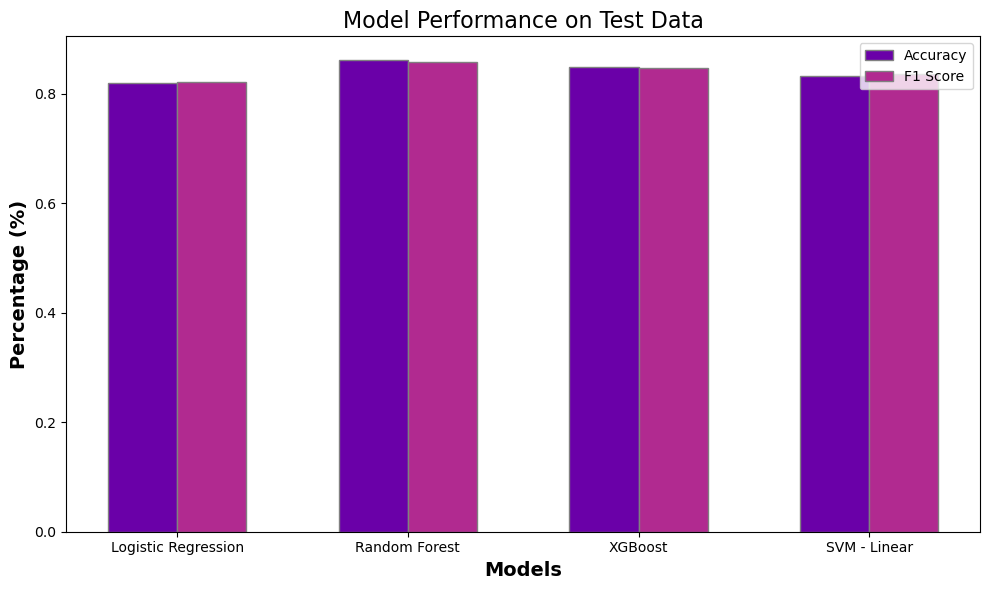

In [27]:
# Model performance metrics (actual values for test data)
accuracy = [0.8198, 0.8616, 0.8486, 0.8329]  # Values for test accuracy
f1_score = [0.8215, 0.8569, 0.8466, 0.8366]  # Values for test F1 score

# Bar plot for model performance
plt.figure(figsize=(10, 6))
bars1 = plt.bar(r1, accuracy, color=colors[0], width=bar_width, edgecolor='grey', label='Accuracy')
bars2 = plt.bar(r2, f1_score, color=colors[1], width=bar_width, edgecolor='grey', label='F1 Score')

# Add labels and title
plt.xlabel('Models', fontweight='bold', fontsize=14)
plt.ylabel('Percentage (%)', fontweight='bold', fontsize=14)
plt.title('Model Performance on Test Data', fontsize=16)
plt.xticks([r + bar_width / 2 for r in range(len(models))], models)

# Show plot
plt.legend()
plt.tight_layout()
plt.show()